<div class='heading'>
    <div style='float:left;'><h1>CPSC 4300/6300: Applied Data Science</h1></div>
    <img style="float: right; padding-right: 10px; width: 65px" src="https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/images/clemson_paw.png"> </div>


## Week 7: Frequent Itemset Mining & Rule Association

**Clemson University**<br>
**Spring 2022**<br>
**Instructor(s):** Nina Hubig <br>
**Author(s):** Chris Kalahiki

---

In [ ]:
""" RUN THIS CELL TO GET THE RIGHT FORMATTING """
import requests
from IPython.core.display import HTML
css_file = 'https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/css/cpsc6300.css'
styles = requests.get(css_file).text
HTML(styles)

**Warning: In addition to the packages that we have used up to this point, we will also be using the mlxtend package for some frequent itemset mining functionality. Be sure to install this package before continuing.**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from pandas.plotting import parallel_coordinates

%matplotlib inline

## Learning Goals

By the end of this lab, you should be able to:
- Understand the Apriori algorithm
- Make use of the mlxtend package to mine frequent itemset sets
- Create a couple new visualizations that show the results of frequent itemset mining

### About Aprior Algorithm

* Inventation
> This algorithm, introduced by R Agrawal and R Srikant in 1994 has great significance in data mining. We shall see the importance of the apriori algorithm in data mining in this article
* Brief Introduction with Examples
This small story will help you understand the concept better. You must have noticed that the local vegetable seller always bundles onions and potatoes together. He even offers a discount to people who buy these bundles.

**Why does he do so?**

He realises that people who buy potatoes also buy onions. Therefore, by bunching them together, he makes it easy for the customers. At the same time, he also increases his sales performance. It also allows him to offer discounts.Similarly, you go to a supermarket, and you will find bread, butter, and jam bundled together. It is evident that the idea is to make it comfortable for the customer to buy these three food items in the same place.


The Walmart beer diaper parable is another example of this phenomenon. People who buy diapers tend to buy beer as well. The logic is that raising kids is a stressful job. People take beer to relieve stress. Walmart saw a spurt in the sale of both diapers and beer.

* What is the Apriori Algorithm?

**Apriori algorithm, a classic algorithm, is useful in mining frequent itemsets and relevant association rules. Usually, you operate this algorithm on a database containing a large number of transactions. One such example is the items customers buy at a supermarket.**

It helps the customers buy their items with ease, and enhances the sales performance of the departmental store.

This algorithm has utility in the field of healthcare as it can help in detecting adverse drug reactions (ADR) by producing association rules to indicate the combination of medications and patient characteristics that could lead to ADRs

* Apriori Algorithm – An Odd Name
It has got this odd name because it uses ‘prior’ knowledge of frequent itemset properties. The credit for introducing this algorithm goes to Rakesh Agrawal and Ramakrishnan Srikant in 1994. We shall now explore the apriori algorithm implementation in detail.

In [ ]:
# loads and displays our data
import io
from google.colab import files


uploaded = files.upload()
data = pd.read_csv(io.BytesIO(uploaded['groceries - groceries.csv']))
print(data)
#data = pd.read_csv("data/groceries - groceries.csv")
#data.head()


Saving groceries - groceries.csv to groceries - groceries.csv
      Item(s)               Item 1               Item 2            Item 3  \
0           4         citrus fruit  semi-finished bread         margarine   
1           3       tropical fruit               yogurt            coffee   
2           1           whole milk                  NaN               NaN   
3           4            pip fruit               yogurt      cream cheese   
4           4     other vegetables           whole milk    condensed milk   
...       ...                  ...                  ...               ...   
9830       17              sausage              chicken              beef   
9831        1    cooking chocolate                  NaN               NaN   
9832       10              chicken         citrus fruit  other vegetables   
9833        4  semi-finished bread        bottled water              soda   
9834        5              chicken       tropical fruit  other vegetables   

             

Let's start by trying to visualize the data.

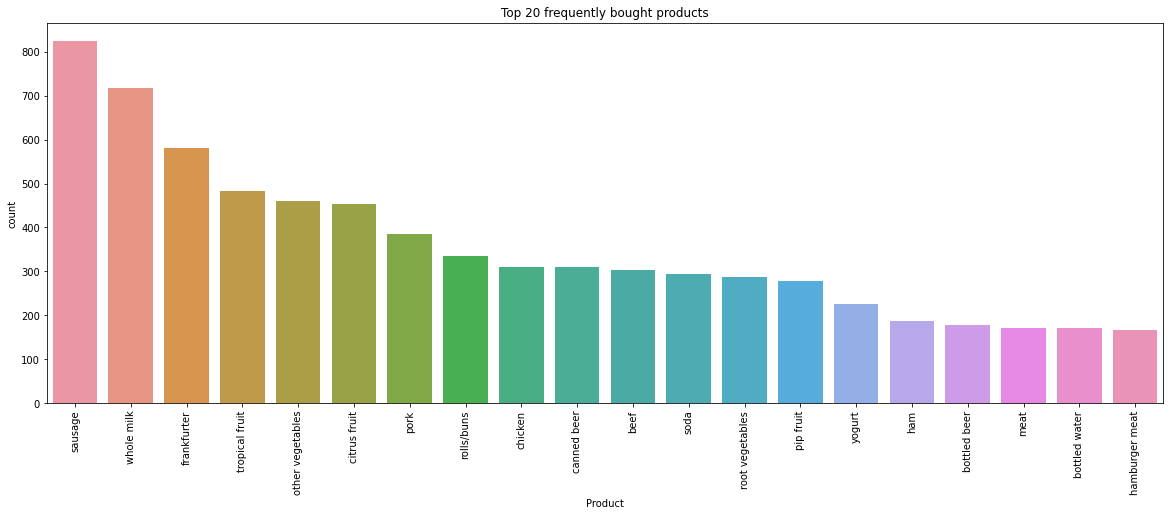

In [ ]:
plt.rcParams['figure.figsize']=20,7
sns.countplot(data=data, x=data['Item 1'], order=data['Item 1'].value_counts().head(20).index)
plt.xticks(rotation=90)
plt.xlabel('Product')
plt.title('Top 20 frequently bought products')
plt.show()

Let's create a list of transactions.

In [ ]:
records = []
for i in range(0, len(data)):
    records.append([str(data.values[i,j]) for j in range(1, data.values[i, 0]+1)])

Let's analyze the no. of items wrt each transaction.

In [ ]:
counts = [len(record) for record in records]
print(f'50 percent of the transactions are having items below or equal to {np.quantile(counts, .5)} only')
print(f'particular transaction having a maximum of {np.quantile(counts, 1)} items in it')

50 percent of the transactions are having items below or equal to 3.0 only
particular transaction having a maximum of 32 items in it


Now we will create a one-hot encoder to use going forward.

In [ ]:
te = TransactionEncoder()
onehot = te.fit_transform(records)
onehot = pd.DataFrame(onehot, columns = te.columns_)

print(f'Shape of encoded data: {onehot.shape[0]} rows and {onehot.shape[1]} columns')

Shape of encoded data: 9835 rows and 169 columns


Due to complexity we are reducing the number of items by selecting particular items alone.

In [ ]:
onehot = onehot.loc[:, ['bottled beer', 'bottled water', 'brandy', 'brown bread', 'butter', 'syrup',
                    'sweet spreads', 'beverages', 'berries', 'beef', 'bathroom cleaner', 'baking powder', 'bags',
                    'baby food', 'baby cosmetics', 'Instant food products', 'tea', 'toilet cleaner', 'vinegar', 'waffles', 'whisky',
                    'white bread', 'white wine', 'yogurt', 'zwieback', 'whole milk', 'whipped/sour cream', 'abrasive cleaner']]

print(f'Shape of encoded data: {onehot.shape[0]} rows and {onehot.shape[1]} columns')

Shape of encoded data: 9835 rows and 28 columns


### How does the Apriori Algorithm in Data Mining work?

* Consider a supermarket scenario where the itemset is I = {Onion, Burger, Potato, Milk, Beer}. The database consists of six transactions where 1 represents the presence of the item and 0 the absence.

![](https://www.digitalvidya.com/wp-content/uploads/2018/11/01.jpg)

#### Step -01
Create a frequency table of all the items that occur in all the transactions. Now, prune the frequency table to include only those items having a threshold support level over 50%. We arrive at this frequency table.

* All subsets of a frequent itemset should be frequent.
* In the same way, the subsets of an infrequent itemset should be infrequent.
* Set a threshold support level. In our case, we shall fix it at 50%

![](https://www.digitalvidya.com/wp-content/uploads/2018/11/02.jpg)

#### Step -02

* Make pairs of items such as OP, OB, OM, PB, PM, BM. This frequency table is what you arrive at.

![](https://www.digitalvidya.com/wp-content/uploads/2018/11/03.jpg)

#### Step -03
Apply the same threshold support of 50% and consider the items that exceed 50% (in this case 3 and above).
Thus, you are left with OP, OB, PB, and PM
#### Step -04
Step 4
Look for a set of three items that the customers buy together. Thus we get this combination.
* OP and OB gives OPB
* PB and PM gives PBM
#### Step -05

![](https://www.digitalvidya.com/wp-content/uploads/2018/11/04.jpg)
*  Determine the frequency of these two itemsets. You get this frequency table.If you apply the threshold assumption, you can deduce    that the set of three items frequently purchased by the customers is OPB.
* We have taken a simple example to explain the apriori algorithm in data mining. In reality, you have hundreds and thousands of such combinations.


Let's generate the frequent itemset using apriori with minimum support of 0.01% and maximum item per transaction restricted to 3.

In [ ]:

frequent_itemsets=apriori(onehot, min_support=0.0001, use_colnames=True, max_len=3)
frequent_itemsets

support                                           itemsets
0     0.080529                                     (bottled beer)
1     0.110524                                    (bottled water)
2     0.004169                                           (brandy)
3     0.064870                                      (brown bread)
4     0.055414                                           (butter)
...        ...                                                ...
1006  0.010880           (yogurt, whipped/sour cream, whole milk)
1007  0.000712             (abrasive cleaner, yogurt, whole milk)
1008  0.000102     (abrasive cleaner, yogurt, whipped/sour cream)
1009  0.000203         (whipped/sour cream, zwieback, whole milk)
1010  0.000508  (abrasive cleaner, whipped/sour cream, whole m...

[1011 rows x 2 columns]


### Detailed Theory

**Three significant components comprise the apriori algorithm. They are as follows.**

* Support
* Confidence
* Lift

**This example will make things easy to understand. Let us suppose you have 2000 customer transactions in a supermarket. You have to find the Support, Confidence, and Lift for two items, say bread and jam. It is because people frequently bundle these two items together.**
Out of the 2000 transactions, 200 contain jam whereas 300 contain bread. These 300 transactions include a 100 that includes bread as well as jam. Using this data, we shall find out the support, confidence, and lift.
#### SUPPORT
Support is the default popularity of any item. You calculate the Support as a quotient of the division of the number of transactions containing that item by the total number of transactions. Hence, in our example,

* Support (Jam) = (Transactions involving jam) / (Total Transactions)

                       *  = 200/2000 = 10%
#### Confidence
It is the likelihood that customer bought both bread and jam. Dividing the number of transactions that include both bread and jam by the total number of transactions will give the Confidence figure.

* Confidence = (Transactions involving both bread and jam) / (Total Transactions involving jam)

                    = 100/200 = 50%                      
                       
  * It implies that 50% of customers who bought jam bought bread as well
  
####  Lift
**According to our example, Lift is the increase in the ratio of the sale of bread when you sell jam. The mathematical formula of Lift is as follows.**

* Lift = (Confidence (Jam͢͢ – Bread)) / (Support (Jam))

      = 50 / 10 = 5
It says that the likelihood of a customer buying both jam and bread together is 5 times more than the chance of purchasing jam alone. If the Lift value is less than 1, it entails that the customers are unlikely to buy both the items together. Greater the value, the better is the combination.

Next, we will generate association rules with mlxtend's association_rules function.

In [ ]:
rules=association_rules(frequent_itemsets)
rules.shape

(164, 9)

Now we can try pruning the generated rules using multiple filters.

In [ ]:
targeted_rules = rules[rules['antecedents'] == {'baby food'}].copy()
targeted_rules

antecedents                        consequents  antecedent support  \
0    (baby food)                      (brown bread)            0.000102   
1    (baby food)                           (butter)            0.000102   
2    (baby food)                          (waffles)            0.000102   
3    (baby food)                      (white bread)            0.000102   
4    (baby food)                           (yogurt)            0.000102   
5    (baby food)               (whipped/sour cream)            0.000102   
37   (baby food)              (brown bread, butter)            0.000102   
42   (baby food)             (waffles, brown bread)            0.000102   
45   (baby food)         (white bread, brown bread)            0.000102   
48   (baby food)              (yogurt, brown bread)            0.000102   
51   (baby food)  (whipped/sour cream, brown bread)            0.000102   
64   (baby food)                  (waffles, butter)            0.000102   
67   (baby food)              (white bread, butter)            0.000102   
70   (baby food)                   (yogurt, butter)            0.000102   
73   (baby food)       (whipped/sour cream, butter)            0.000102   
120  (baby food)             (waffles, white bread)            0.000102   
123  (baby food)                  (yogurt, waffles)            0.000102   
126  (baby food)      (waffles, whipped/sour cream)            0.000102   
129  (baby food)              (yogurt, white bread)            0.000102   
132  (baby food)  (white bread, whipped/sour cream)            0.000102   
135  (baby food)       (yogurt, whipped/sour cream)            0.000102   

     consequent support   support  confidence        lift  leverage  \
0              0.064870  0.000102         1.0   15.415361  0.000095   
1              0.055414  0.000102         1.0   18.045872  0.000096   
2              0.038434  0.000102         1.0   26.018519  0.000098   
3              0.042095  0.000102         1.0   23.756039  0.000097   
4              0.139502  0.000102         1.0    7.168367  0.000087   
5              0.071683  0.000102         1.0   13.950355  0.000094   
37             0.005796  0.000102         1.0  172.543860  0.000101   
42             0.002339  0.000102         1.0  427.608696  0.000101   
45             0.004677  0.000102         1.0  213.804348  0.000101   
48             0.014540  0.000102         1.0   68.776224  0.000100   
51             0.004677  0.000102         1.0  213.804348  0.000101   
64             0.003559  0.000102         1.0  281.000000  0.000101   
67             0.004270  0.000102         1.0  234.166667  0.000101   
70             0.014642  0.000102         1.0   68.298611  0.000100   
73             0.010168  0.000102         1.0   98.350000  0.000101   
120            0.003559  0.000102         1.0  281.000000  0.000101   
123            0.007524  0.000102         1.0  132.905405  0.000101   
126            0.005084  0.000102         1.0  196.700000  0.000101   
129            0.009049  0.000102         1.0  110.505618  0.000101   
132            0.005491  0.000102         1.0  182.129630  0.000101   
135            0.020742  0.000102         1.0   48.210784  0.000100   

     conviction  
0           inf  
1           inf  
2           inf  
3           inf  
4           inf  
5           inf  
37          inf  
42          inf  
45          inf  
48          inf  
51          inf  
64          inf  
67          inf  
70          inf  
73          inf  
120         inf  
123         inf  
126         inf  
129         inf  
132         inf  
135         inf

<div class="exercise"><b>Exercise #1</b>: </div>

Using the targeted_rules DataFrame above, filter the rules to retain only those rules that meet both of the following criteria:
- Rules with a confidence greater than 0.85
- Rules with a lift greater than 1.00

In [ ]:
targeted_rules=apriori(onehot, min_support=0.0001, use_colnames=True, max_len=3)
targeted_rules


support                                           itemsets
0     0.080529                                     (bottled beer)
1     0.110524                                    (bottled water)
2     0.004169                                           (brandy)
3     0.064870                                      (brown bread)
4     0.055414                                           (butter)
...        ...                                                ...
1006  0.010880           (yogurt, whipped/sour cream, whole milk)
1007  0.000712             (abrasive cleaner, yogurt, whole milk)
1008  0.000102     (abrasive cleaner, yogurt, whipped/sour cream)
1009  0.000203         (whipped/sour cream, zwieback, whole milk)
1010  0.000508  (abrasive cleaner, whipped/sour cream, whole m...

[1011 rows x 2 columns]

In [ ]:
rules=association_rules(frequent_itemsets, metric='lift', min_threshold=1)
rules.head()


antecedents      consequents  antecedent support  consequent support  \
0   (bottled beer)  (bottled water)            0.080529            0.110524   
1  (bottled water)   (bottled beer)            0.110524            0.080529   
2   (bottled beer)         (brandy)            0.080529            0.004169   
3         (brandy)   (bottled beer)            0.004169            0.080529   
4   (bottled beer)         (butter)            0.080529            0.055414   

    support  confidence      lift  leverage  conviction  
0  0.015760    0.195707  1.770726  0.006860    1.105911  
1  0.015760    0.142594  1.770726  0.006860    1.072388  
2  0.000915    0.011364  2.725887  0.000579    1.007278  
3  0.000915    0.219512  2.725887  0.000579    1.178073  
4  0.005796    0.071970  1.298756  0.001333    1.017839

In [ ]:
#targeted_rules['itemsets'].value_counts()
#targeted_rules= apriori(onehot=0.07, use_colnames=True)
#rules=association_rules(frequent_itemsets, metric='lift', min_threshold=1)
#rules.head()
filtered_rules= rules[ (rules['lift'] >=1) &(rules['confidence'] >=0.85)]
filtered_rules

antecedents           consequents  \
88                       (baby food)         (brown bread)   
112                      (baby food)              (butter)   
293                      (baby food)             (waffles)   
294                      (baby food)         (white bread)   
297                      (baby food)              (yogurt)   
...                              ...                   ...   
4276     (vinegar, abrasive cleaner)          (whole milk)   
4354     (abrasive cleaner, waffles)  (whipped/sour cream)   
4360                (yogurt, whisky)          (whole milk)   
4362            (whisky, whole milk)              (yogurt)   
4430  (abrasive cleaner, white wine)          (whole milk)   

      antecedent support  consequent support   support  confidence       lift  \
88              0.000102            0.064870  0.000102         1.0  15.415361   
112             0.000102            0.055414  0.000102         1.0  18.045872   
293             0.000102            0.038434  0.000102         1.0  26.018519   
294             0.000102            0.042095  0.000102         1.0  23.756039   
297             0.000102            0.139502  0.000102         1.0   7.168367   
...                  ...                 ...       ...         ...        ...   
4276            0.000203            0.255516  0.000203         1.0   3.913649   
4354            0.000203            0.071683  0.000203         1.0  13.950355   
4360            0.000102            0.255516  0.000102         1.0   3.913649   
4362            0.000102            0.139502  0.000102         1.0   7.168367   
4430            0.000102            0.255516  0.000102         1.0   3.913649   

      leverage  conviction  
88    0.000095         inf  
112   0.000096         inf  
293   0.000098         inf  
294   0.000097         inf  
297   0.000087         inf  
...        ...         ...  
4276  0.000151         inf  
4354  0.000189         inf  
4360  0.000076         inf  
4362  0.000087         inf  
4430  0.000076         inf  

[164 rows x 9 columns]

From here, we can take a look at the 'baby foods' relevant consequents. To do this, we will use a [`pivot table`](https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html) using pandas. From there, we will use seaborn's [`heatmap`](https://seaborn.pydata.org/generated/seaborn.heatmap.html) to visualize the results.

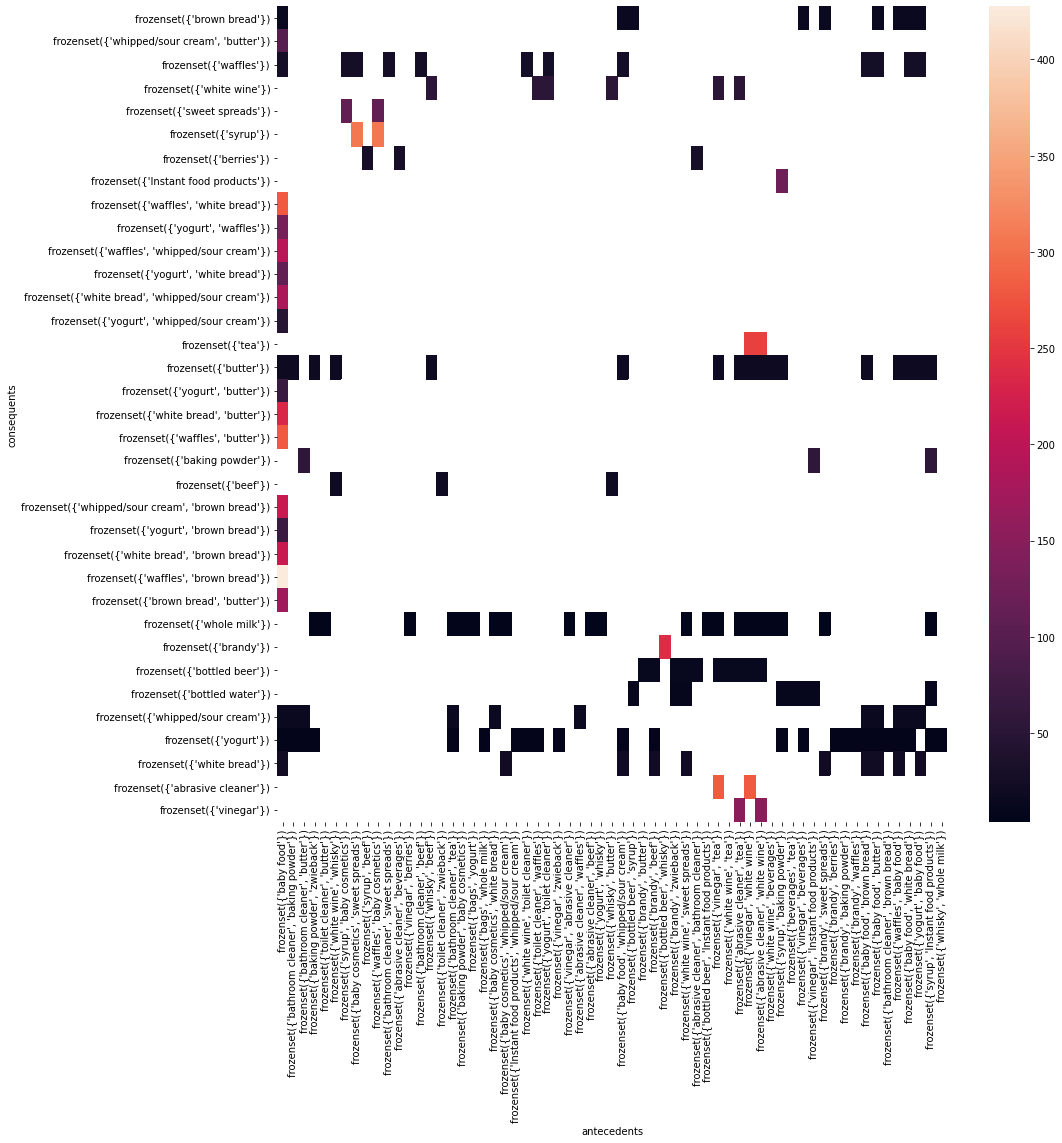

In [ ]:
plt.rcParams['figure.figsize'] = (15, 15)
support_table = filtered_rules.pivot(index='consequents', columns='antecedents', values='lift')
sns.heatmap(support_table)

In [ ]:
rules['antecedent'] = rules['antecedents'].apply(lambda antecedent: list(antecedent)[0])
rules['consequent'] = rules['consequents'].apply(lambda consequent: list(consequent)[0])
rules['rule'] = rules.index
coords = rules[['antecedent','consequent','rule']]
df=coords.head(100)
coords.head(100)

antecedent          consequent  rule
0         bottled beer       bottled water     0
1        bottled water        bottled beer     1
2         bottled beer              brandy     2
3               brandy        bottled beer     3
4         bottled beer              butter     4
..                 ...                 ...   ...
95         brown bread              yogurt    95
96         brown bread          whole milk    96
97          whole milk         brown bread    97
98  whipped/sour cream         brown bread    98
99         brown bread  whipped/sour cream    99

[100 rows x 3 columns]

Now, we can generate a parallel coordinate plot to visualize the association rules.

<div class="exercise"><b>Exercise #2</b>: </div>

Visualize the association rules using a [`parallel coordinate`](https://pandas.pydata.org/docs/reference/api/pandas.plotting.parallel_coordinates.html) plot. Because of the large number of rules, we will need to modify the [`legend`](https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.legend.html) of the plot. For the best results, I recommend using three columns for the legend.

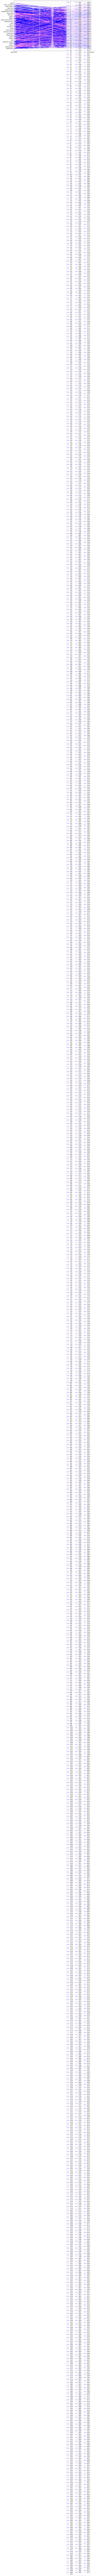

In [ ]:
plt.figure(figsize=(12,8))
parallel_coordinates(coords, 'rule', color=['blue','violet'])
#plt.plot(x,y,label='blue')
#plt.plot(x,y+2,color='violet',label='violet')

plt.legend(ncol=3)

plt.show()

#plt.legend(['even','odd'])

#plt.show()

#### Apriori Algorithm – Pros
* Easy to understand and implement
* Can use on large itemsets
#####  Apriori Algorithm – Cons
* At times, you need a large number of candidate rules. It can become computationally expensive.
* It is also an expensive method to calculate support because the calculation has to go through the entire database.
##### Apriori Algorithm – Limitations
* The process can sometimes be very tedious.
* How to Improve the Efficiency of the Apriori Algorithm?

#### Use the following methods to improve the efficiency of the apriori algorithm.

* Transaction Reduction – A transaction not containing any frequent k-itemset becomes useless in subsequent scans.
* Hash-based Itemset Counting – Exclude the k-itemset whose corresponding hashing bucket count is less than the threshold is an infrequent itemset.
* There are other methods as well such as partitioning, sampling, and dynamic itemset counting